In [41]:
import hashlib
import json
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [114]:
# Input metadata.
exp_dirs_code_hashes = [# [ '../experiment_data/pilot_june9/', 'thowpbr_pilot0'],  # format too old
                        # ['../experiment_data/pilot_june12a/', 'thowpbr_pilot0'],  # format too old
                        ['../experiment_data/pilot_june12b/', 'thowpbr_pilot0'],
                        ['../experiment_data/june16a/', 'thowpbr_main0'],
                        ['../experiment_data/june16b/', 'thowpbr_main0'],
                        ['../experiment_data/june16c/', 'thowpbr_main0'],
                       ]

csv_names = ['mturk.csv', 'qual.csv', 'main.csv']
log_dir = 'www/log/'
feedback_dir = 'www/feedback'

# Set by MP
METERS_FOR_SUCCESS = 3  # how many meters from the target pano count as success

# Set by task tuple creation.
MIN_GOLD_NAV = 4
MAX_GOLD_NAV = 35

# Set by HIT.
ORACLE_FUTURE_LEN = 5

# Load house targets.
tasks_fn = 'resources/house_target_tuple.json'
with open(tasks_fn, 'r') as f:
    house_target_tuple = json.load(f)
all_targets = set()
for scan in house_target_tuple:
    all_targets = all_targets.union(set([task_tuple[0] for task_tuple in house_target_tuple[scan]]))
    
# Get distances and hops across scans.
import networkx as nx
from generate_start_end_pairs import load_nav_graphs
house_hops = {}
house_dists = {}
for house in set(house_target_tuple.keys()):
    graph = load_nav_graphs([house])[house]
    hops = dict(nx.all_pairs_dijkstra_path(graph))
    house_hops[house] = hops
    dists = dict(nx.all_pairs_dijkstra_path_length(graph))
    house_dists[house] = dists
    
def get_shortest_planner_path(house, start_pano, end_panos):
    full_trajs = [house_hops[house][start_pano][end_pano] for end_pano in end_panos]
    full_traj_lens = [len(full_trajs[idx]) for idx in range(len(full_trajs))]
    return full_trajs[full_traj_lens.index(min(full_traj_lens))]

def calculate_success(scan, path, gold, within_meters=0, within_hops=0):
    return 1. if (house_dists[scan][path[-1]][gold[-1]] <= within_meters or
                 len(house_hops[scan][path[-1]][gold[-1]]) <= within_hops) else 0.

def calculate_oracle_success(scan, path, gold, within_meters=0, within_hops=0):
    return 1. if np.any([house_dists[scan][path_pano][gold[-1]] <= within_meters or
                        len(house_hops[scan][path_pano][gold[-1]]) <= within_hops
                        for path_pano in path]) else 0.

def get_oracle_first_nearest(scan, path, gold, within_meters=0, within_hops=0):
    for path_pano in path:
        if (house_dists[scan][path_pano][gold[-1]] <= within_meters or
            len(house_hops[scan][path_pano][gold[-1]]) <= within_hops):
             return path_pano
    return None

def calculate_spl(scan, path, gold, within_meters=0, within_hops=0):
    return 1. / len(path) if calculate_success(scan, path, gold,
                                               within_meters=within_meters, within_hops=within_hops) else 0.

def calculate_oracle_spl(scan, path, gold, within_meters=0, within_hops=0):
    nearest = get_oracle_first_nearest(scan, path, gold, within_meters=within_meters, within_hops=within_hops)
    if nearest is not None:
        return 1. / len(path[:path.index(nearest)]) if path.index(nearest) > 0 else 1.
    return 0.

def flip_dict(d):
    g = {}
    for key in d:
        if type(d[key]) is list:
            for e in d[key]:
                g[e] = key
        else:
            if d[key] not in g:
                g[d[key]] = []
            g[d[key]].append(key)
    return g
    
# Output metadata.
games_fn = '../tasks/dialog_navigation/all.json'
instruction_following_dir = '../tasks/instruction_following/'
question_asking_dir = '../tasks/question_asking/'
question_answering_dir = '../tasks/question_answering/'
dialog_navigation_dir = '../tasks/dialog_navigation/'

In [115]:
# Read in the CSV from Turk and connect each player to their respective logfile to rebuild games.
workers_read = workers_bad_code = workers_wrong_hash = num_unpaired = workers_lost = 0
games_logs_read = invalid_game_logs = 0
skipped_for_invalid_pano = skipped_for_invalid_target = 0
games_timed_out = 0
games = pd.DataFrame(columns=["idx",  # own idx in dataframe
                              "navigator",  # uid of the navigator
                              "oracle",  # uid of the oracle
                              "navigator_quality",  # rated quality of the navigator from the oracle
                              "oracle_quality",  # rated quality of the oracle from the navigator
                              "scan",  # the house the game took place in
                              "target",  # the target object described by the hint
                              "start_pano",  # the starting panorama
                              "end_panos",  # list of valid ending panoramas
                              "R2R_spl",  # shortest_path/path_len if success, 0 otherwise
                              "R2R_oracle_spl",  # shortest_path/path_len_trimmed
                              "nav_steps",  # the panorama jumps taken during navigation (no camera movements)
                              "nav_camera",  # the camera movements preceeding nav steps where questions were asked
                              "dialog_history",  # the full dialog history (both navigator and oracle)
                              "stop_history",  # list of 'nav_step' idxs where navigator attempted a stop action
                              "planner_nav_steps",  # the path the planner would have taken from start to end
                              ])
skipped_game_uids = set()
feedbacks = []
workers_to_uids = {}  # str->str
uids_to_workers = {}
workers_to_timeouts = {}  # str->count
uids_timeout = []
for exp_dir, surveycode_hash in exp_dirs_code_hashes:
    print("Reading from '%s'" % exp_dir)
    for csv_name in csv_names:
        csv_fn = os.path.join(exp_dir, csv_name)
        if not os.path.isfile(csv_fn):
            continue
        print("Reading from csv name '%s'" % csv_name)
        mturk = pd.read_csv(csv_fn)
        for idx in mturk.index:
            workers_read += 1 
            # Approve surveycode.
            surveycode = mturk['Answer.surveycode'][idx]
            wid = mturk['WorkerId'][idx]
            if wid not in workers_to_uids:
                workers_to_uids[wid] = []
            if '_' not in surveycode or surveycode.count('_') != 1:
                print('WARNING: worker %s has invalid surveycode "%s"' % (wid, surveycode))
                workers_bad_code += 1
                continue
            uid, hashcode = mturk['Answer.surveycode'][idx].split('_')
            workers_to_uids[wid].append(uid)
            uids_to_workers[uid] = wid
            if uid in skipped_game_uids:
                continue
            hash_str = 'phm_salted_hash%s%s' % (uid, surveycode_hash)
            correcthash = hashlib.sha1(hash_str.encode('utf-8')).hexdigest()[:13]
            if correcthash != hashcode:
                print('WARNING: worker %s has wrong hash %s does not match target %s' % (wid, hashcode, correcthash))
                workers_wrong_hash += 1
                continue

            # Find the feedback file for this user.
            uid_feedback_fn = None
            for _, _, fns in os.walk(os.path.join(exp_dir, feedback_dir)):
                for fn in fns:
                    if fn.split('.')[-1] == 'json' and fn.split('_')[0] == uid:
                        uid_feedback_fn = os.path.join(exp_dir, feedback_dir, fn)
            if uid_feedback_fn is None:
                workers_lost += 1
                continue
            with open(uid_feedback_fn) as f:
                feedback = json.load(f)
            role = 'navigator' if feedback['navigator'] == uid else 'oracle'
            pid_role = 'navigator' if role == 'oracle' else 'oracle'
            pid = feedback['navigator'] if role == 'oracle' else feedback['oracle']
            pid_rating = int(feedback['rating']) if feedback['rating'] is not None else None
            str_feedback = feedback['free_form_feedback']
            feedbacks.append((wid, str_feedback))

            # Already have game information for this user, so we just need to update the game with their
            # rating of their partner.
            if len(pid) > 0:
                if pid in games.loc[games['navigator'] == pid]['navigator'].values:
                    games.at[games['navigator'] == pid, 'navigator_quality'] =\
                        int(pid_rating) if pid_rating is not None else -1
                    continue
                elif pid in games.loc[games['oracle'] == pid]['oracle'].values:
                    games.at[games['oracle'] == pid, 'oracle_quality'] =\
                        int(pid_rating) if pid_rating is not None else -1
                    continue

            # Find the logfile and partner id for this user.
            game_log_found = False
            for _, _, fns in os.walk(os.path.join(exp_dir, log_dir)):
                for fn in fns:
                    if ('.' in fn and fn.split('.')[-1] == 'log' and
                        '_' in fn and uid in fn.split('.')[0].split('_')):
                        games_logs_read += 1
                        game_log_found = True
                        uids_in_fn = fn.split('.')[0].split('_')
                        pid = uids_in_fn[0] if uid == uids_in_fn[1] else uids_in_fn[1]

                        # Need to create game information for this unseen pair.
                        navigator = oracle = None
                        navigator_quality = oracle_quality = -1
                        house = target = start_pano = end_panos = None
                        success = False
                        timed_out = False
                        nav_steps = []
                        nav_camera = []
                        dialog_history = []
                        stop_history = []
                        curr_pano = None
                        curr_camera_moves = []
                        curr_turn = "navigator"
                        game_log_fn = os.path.join(exp_dir, log_dir, fn)
                        with open(game_log_fn, 'r') as f:
                            logfile_lines = f.readlines()
                        target_valid = True
                        for line in logfile_lines:
                            line_parts = line.strip().split('\t')
                            time, sender, receiver, data_str = line_parts
                            data_str = re.sub(r'(?!(([^"]*"){2})*[^"]*$)\'', "\\'", data_str)
                            data_str = data_str.replace("'", '"')
                            line_data = json.loads(data_str)

                            if line_data['action'] == 'set_house':
                                house = line_data['value']
                            elif line_data['action'] == 'set_target_obj':
                                target = line_data['value']
                                if target not in all_targets:
                                    target_valid = False
                                    break
                            elif line_data['action'] == 'set_start_pano' and start_pano is None:
                                start_pano = line_data['value']
                                curr_pano = start_pano
                                nav_steps.append(curr_pano)
                            elif line_data['action'] == 'set_end_panos':
                                end_panos = line_data['value'].split(',')
                            elif (line_data['action'] == 'set_aux' and 
                                  "You are The Navigator" in line_data["message"] and receiver == uid):
                                navigator = uid
                                oracle = pid
                                oracle_quality = int(pid_rating) if pid_rating is not None else -1
                            elif (line_data['action'] == 'set_aux' and
                                  "You are The Oracle" in line_data["message"] and receiver == uid):
                                oracle = uid
                                navigator = pid
                                navigator_quality = int(pid_rating) if pid_rating is not None else -1
                            elif line_data['action'] == 'nav':
                                if line_data['message']['img_id'] != curr_pano:
                                    curr_pano = line_data['message']['img_id']
                                    nav_steps.append(curr_pano)
                                    curr_camera_moves = []
                                curr_camera_moves.append({'pano': line_data['message']['img_id'],
                                                          'heading': (line_data['message']['rot']['_x'] + 1) 
                                                          * np.pi,
                                                          'elevation': (line_data['message']['rot']['_y'] + 35)
                                                          * 0.5,
                                                         })
                            elif line_data['action'] == 'chat':
                                if curr_turn == 'navigator':  # add camera steps preceeding question
                                    nav_camera.append({"nav_idx": len(nav_steps) - 1,
                                                       "dia_idx": len(dialog_history),
                                                       "message": curr_camera_moves})
                                if curr_turn == role:
                                    dialog_history.append({"uid": uid,
                                                           "role": role,
                                                           "nav_idx": len(nav_steps) - 1,
                                                           "message": line_data['message'].replace('"', "'")})
                                else:
                                    dialog_history.append({"uid": pid,
                                                           "role": pid_role,
                                                           "nav_idx": len(nav_steps) - 1,
                                                           "message": line_data['message'].replace('"', "'")})
                                curr_turn = "navigator" if curr_turn == "oracle" else "oracle"
                            elif line_data['action'] == 'guess_stop':
                                stop_history.append(len(nav_steps))
                            elif line_data['action'] == 'set_aux' and 'Congrats, ' in line_data['message']:
                                success = True
                            elif line_data['action'] == 'set_aux' and 'too long to respond' in line_data['message']:
                                timed_out = True
                                # Assign blame.
                                if curr_turn == 'navigator':
                                    uids_timeout.append(navigator)
                                else:
                                    uids_timeout.append(oracle)
                            elif line_data['action'] == 'exit':
                                break  # stop reading the log at exit, even though it might have more junk in it.

                        if not target_valid:
                            skipped_for_invalid_target += 1
                            print("WARNING: skipping game from scan %s due to invalid target %s"
                                      % (house, target))
                            skipped_game_uids = skipped_game_uids.union(set([uid, pid]))
                            break

                        planner_nav_steps = get_shortest_planner_path(house, start_pano, end_panos)

                        # Filter out games where players stepped on included=False cylinders.
                        # This possibility was removed after the pilot.
                        invalid_pano = None
                        for pano in nav_steps:
                            if pano not in house_hops[house]:
                                invalid_pano = pano
                                break
                        if invalid_pano is not None:
                            print("WARNING: skipping game from scan %s due to invalid pano %s"
                                      % (house, invalid_pano))
                            skipped_for_invalid_pano += 1
                            skipped_game_uids = skipped_game_uids.union(set([uid, pid]))
                            break
                        spl = float(calculate_spl(house, nav_steps, planner_nav_steps,
                                                  within_meters=METERS_FOR_SUCCESS))
                        ora_spl = float(calculate_oracle_spl(house, nav_steps, planner_nav_steps,
                                                             within_meters=METERS_FOR_SUCCESS))

                        if timed_out:
                            games_timed_out += 1
                        else:
                            if not success:
                                print("WARNING: game '%s' has no conclusion" %
                                      game_log_fn)
                                invalid_game_logs += 1
                            else:
                                games = games.append({
                                    "idx": len(games),
                                    "navigator": navigator,
                                    "oracle": oracle,
                                    "navigator_quality": navigator_quality,
                                    "oracle_quality": oracle_quality,
                                    "scan": house,
                                    "target": target,
                                    "start_pano": start_pano,
                                    "end_panos": end_panos,
                                    "R2R_spl": spl,
                                    "R2R_oracle_spl": ora_spl,
                                    "nav_steps": nav_steps,
                                    "nav_camera": nav_camera,
                                    "dialog_history": dialog_history,
                                    "stop_history": stop_history,
                                    "planner_nav_steps": planner_nav_steps,
                                }, ignore_index=True)
                    if game_log_found:
                        break
                if game_log_found:
                    break
            if not game_log_found:
                num_unpaired += 1
untracked_blame = 0
for uid in uids_timeout:
    if uid not in uids_to_workers:
        untracked_blame += 1
        continue
    blame_wid = uids_to_workers[uid]
    if blame_wid not in workers_to_timeouts:
        workers_to_timeouts[blame_wid] = 0
    workers_to_timeouts[blame_wid] += 1
    
print("Read %d game logfiles" % games_logs_read)
print("\t%d won and added\n\t%d timed out\n\t%d skipped due to incomplete log\n\t%d skipped due to invalid pano\n\t%d skipped due to invalid target" %
     (len(games), games_timed_out, invalid_game_logs, skipped_for_invalid_pano, skipped_for_invalid_target))
print("Read %d worker rows" % workers_read)
print("\t%d tracked feedback\n\t%d never paired\n\t%d had no feedback file\n\t%d had invalid codes\n\t%d had non-matching hashes" % 
      (len(feedbacks), num_unpaired, workers_lost, workers_bad_code, workers_wrong_hash))
print("\t%d workers caused timeouts and submitted anyway\n\twith %d/%d timeout uids untracked (never submitted)" %
     (len(workers_to_timeouts), untracked_blame, len(uids_timeout)))

with open(games_fn, 'w') as f:
    json.dump(games.to_json(), f)

Reading from '../experiment_data/pilot_june12b/'
Reading from csv name 'mturk.csv'
Reading from '../experiment_data/june16a/'
Reading from csv name 'qual.csv'
Reading from csv name 'main.csv'
Reading from '../experiment_data/june16b/'
Reading from csv name 'qual.csv'
Reading from csv name 'main.csv'
Reading from '../experiment_data/june16c/'
Reading from csv name 'qual.csv'
Reading from csv name 'main.csv'
Read 229 game logfiles
	143 won and added
	77 timed out
	8 skipped due to incomplete log
	1 skipped due to invalid pano
	0 skipped due to invalid target
Read 419 worker rows
	373 tracked feedback
	9 never paired
	32 had no feedback file
	13 had invalid codes
	0 had non-matching hashes
	11 workers caused timeouts and submitted anyway
	with 55/78 timeout uids untracked (never submitted)


0	26	15	(0.58)
1	14	13	(0.93)
2	38	13	(0.34)
3	19	16	(0.84)
4	36	22	(0.61)
5	10	7	(0.70)
6	28	26	(0.93)
7	31	22	(0.71)
8	6	6	(1.00)
9	38	20	(0.53)
10	13	13	(1.00)
11	22	16	(0.73)
12	25	19	(0.76)
13	55	32	(0.58)
14	29	13	(0.45)
15	39	21	(0.54)
16	9	4	(0.44)
17	8	6	(0.75)
18	54	32	(0.59)
19	24	19	(0.79)
20	33	25	(0.76)
21	21	18	(0.86)
22	32	25	(0.78)
23	12	10	(0.83)
24	28	25	(0.89)
25	37	25	(0.68)
26	11	10	(0.91)
27	27	17	(0.63)
28	34	28	(0.82)
29	6	8	(1.33)
30	21	20	(0.95)
31	25	18	(0.72)
32	9	9	(1.00)
33	22	17	(0.77)
34	37	18	(0.49)
35	25	18	(0.72)
36	12	12	(1.00)
37	5	4	(0.80)
38	14	14	(1.00)
39	31	9	(0.29)
40	20	21	(1.05)
41	35	29	(0.83)
42	18	16	(0.89)
43	11	10	(0.91)
44	19	18	(0.95)
45	25	17	(0.68)
46	6	8	(1.33)
47	32	24	(0.75)
48	16	13	(0.81)
49	32	24	(0.75)
50	29	14	(0.48)
51	33	22	(0.67)
52	21	16	(0.76)
53	3	18	(6.00)
54	24	22	(0.92)
55	24	19	(0.79)
56	26	6	(0.23)
57	8	7	(0.88)
58	15	10	(0.67)
59	12	12	(1.00)
60	39	14	(0.36)
61	19	17	(0.89)
62	75	23	(0.31)
63	65	16	(0.25)
64	25	

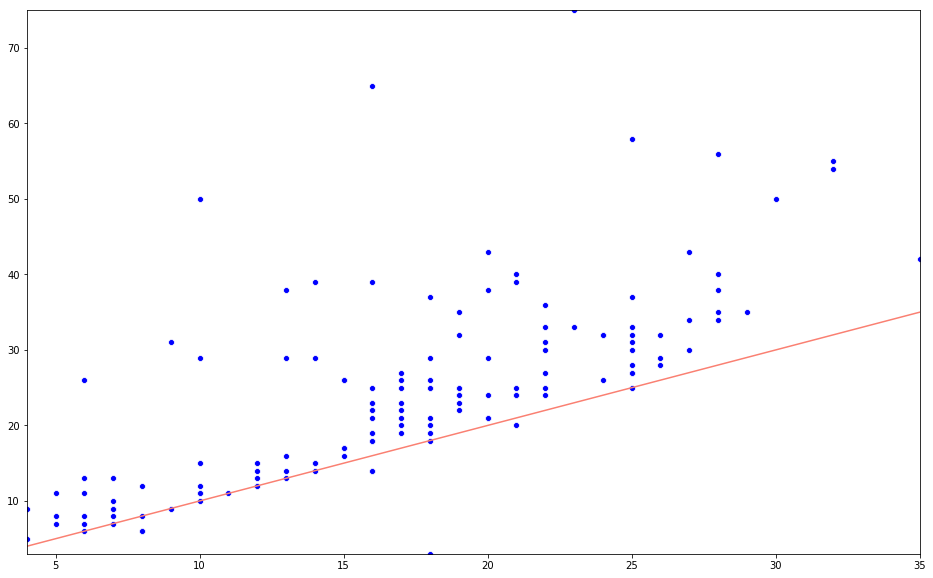

In [102]:
# Nav lengths against shortest path for completed games.
player_lens = []
shortest_lens = []
for idx in games.index:
    player_traj_len = len(games['nav_steps'][idx])
    shortest_traj_len = None
    for obj, start_pano, _, end_panos, end_pano_ds in house_target_tuple[games['scan'][idx]]:
        if (start_pano == games['start_pano'][idx] and
                obj == games['target'][idx] and
                set(end_panos) == set(games['end_panos'][idx])):
            shortest_traj_len = min(end_pano_ds)
    if shortest_traj_len is not None:
        print("%d\t%d\t%d\t(%.2f)" % (idx, player_traj_len, shortest_traj_len, float(shortest_traj_len / player_traj_len)))
        player_lens.append(player_traj_len)
        shortest_lens.append(shortest_traj_len)
    else:
        print("WARNING: task for house %s, target '%s' missing" % (games['scan'][idx], games['target'][idx]))
        
# Scatterplot showing how well players did against gold shortest.
fig, ax = plt.subplots(figsize=(16, 10))
g1 = sns.scatterplot(ax=ax, x=shortest_lens, y=player_lens, color='blue')
g2 = sns.lineplot(ax=ax, x=[MIN_GOLD_NAV, MAX_GOLD_NAV], y=[MIN_GOLD_NAV, MAX_GOLD_NAV], color='salmon')  # Perfect
ax.set(xlim=(min(shortest_lens), max(shortest_lens)),
       ylim=(min(player_lens), max(player_lens)))
plt.show()

26	7	(3.71)
14	7	(2.00)
38	13	(2.92)
19	7	(2.71)
36	7	(5.14)
10	9	(1.11)
28	15	(1.87)
31	13	(2.38)
6	3	(2.00)
38	15	(2.53)
13	1	(13.00)
22	21	(1.05)
25	5	(5.00)
55	11	(5.00)
29	13	(2.23)
39	3	(13.00)
9	7	(1.29)
8	1	(8.00)
54	17	(3.18)
24	11	(2.18)
33	7	(4.71)
21	7	(3.00)
32	11	(2.91)
12	5	(2.40)
28	9	(3.11)
37	5	(7.40)
11	5	(2.20)
27	7	(3.86)
34	11	(3.09)
6	5	(1.20)
21	7	(3.00)
25	11	(2.27)
9	5	(1.80)
22	5	(4.40)
37	9	(4.11)
25	7	(3.57)
12	5	(2.40)
5	9	(0.56)
14	5	(2.80)
31	11	(2.82)
20	7	(2.86)
35	7	(5.00)
18	15	(1.20)
11	7	(1.57)
19	7	(2.71)
25	9	(2.78)
6	1	(6.00)
32	9	(3.56)
16	9	(1.78)
32	9	(3.56)
29	9	(3.22)
33	23	(1.43)
21	7	(3.00)
3	5	(0.60)
24	5	(4.80)
24	11	(2.18)
26	5	(5.20)
8	5	(1.60)
15	7	(2.14)
12	5	(2.40)
39	9	(4.33)
19	5	(3.80)
75	11	(6.82)
65	23	(2.83)
25	3	(8.33)
13	3	(4.33)
26	17	(1.53)
58	13	(4.46)
24	7	(3.43)
20	5	(4.00)
32	5	(6.40)
25	9	(2.78)
30	9	(3.33)
17	5	(3.40)
7	7	(1.00)
15	5	(3.00)
29	9	(3.22)
11	3	(3.67)
31	11	(2.82)
12	5	(2.40)
18	1	(18.00)
13	5	(2.60)
40

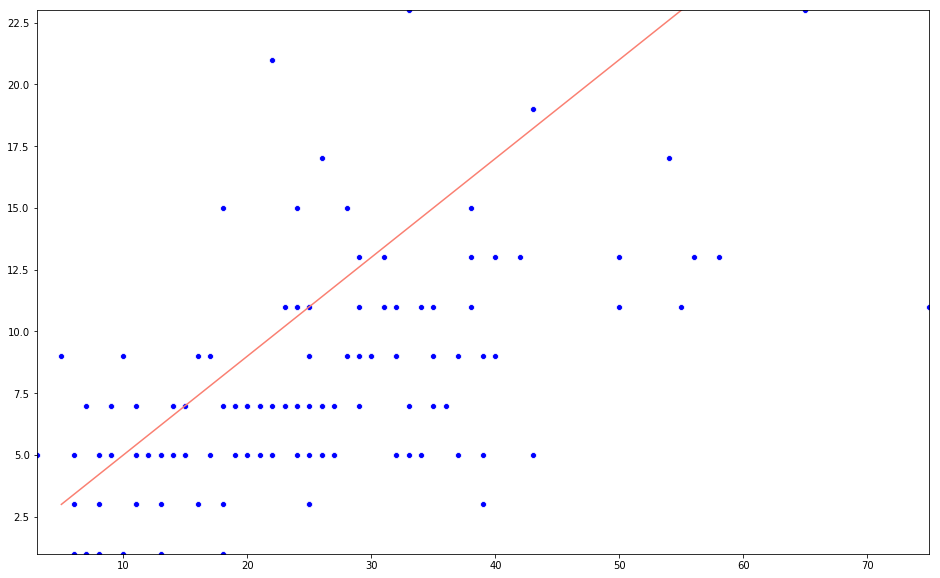

In [103]:
# Nav lengths against dialog lengths for completed games
nav_lens = []
dialog_lens = []
for idx in games.index:
    nav_len = len(games['nav_steps'][idx])
    dialog_len = len(games['dialog_history'][idx]) + 1  # Counts the initial "hint" as a turn to avoid div by zero
    print("%d\t%d\t(%.2f)" % (nav_len, dialog_len, float(nav_len / dialog_len)))
    nav_lens.append(nav_len)
    dialog_lens.append(dialog_len)
        
# Scatterplot showing how well players did against gold shortest.
fig, ax = plt.subplots(figsize=(16, 10))
g1 = sns.scatterplot(ax=ax, x=nav_lens, y=dialog_lens, color='blue')
# "Conservative", asking 1 question every 5 nav turns, gives 2 dialog turns per 5 nav, with an offset of +1 for hint.
g2 = sns.lineplot(ax=ax, x=[5, 5*max(dialog_lens)], y=[2+1, (2*max(dialog_lens))+1], color='salmon')
ax.set(xlim=(min(nav_lens), max(nav_lens)), ylim=(min(dialog_lens), max(dialog_lens)))
plt.show()

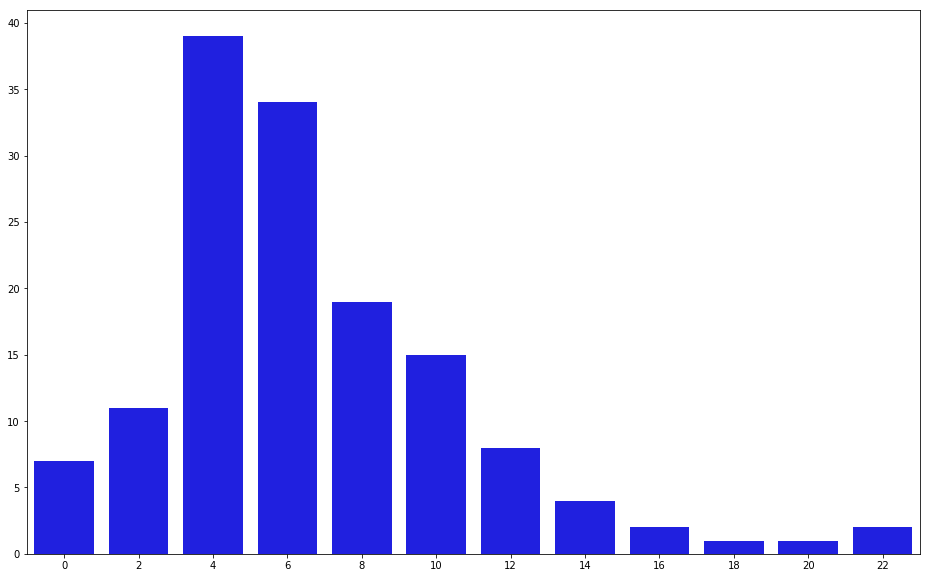

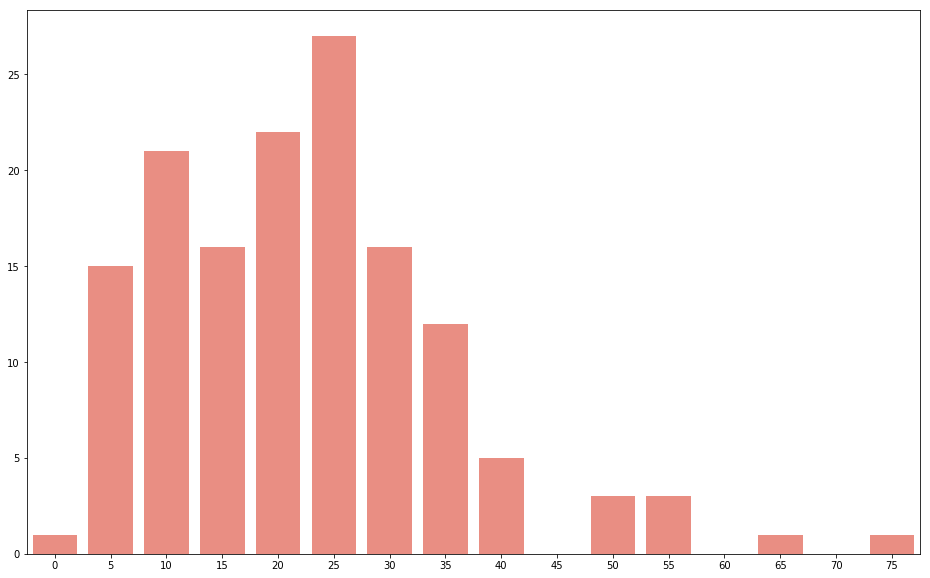

In [104]:
# Distribution of trajectory and dialog lengths.

# Dialog lens.
dialog_bin_size = 2
freq_of_dialog_count_bins = {}
for idx in games.index:
    c = len(games['dialog_history'][idx])
    cbin = c // dialog_bin_size
    if cbin not in freq_of_dialog_count_bins:
        freq_of_dialog_count_bins[cbin] = 0
    freq_of_dialog_count_bins[cbin] += 1
for cbin in range(min(freq_of_dialog_count_bins), max(freq_of_dialog_count_bins)):
    if cbin not in freq_of_dialog_count_bins:
        freq_of_dialog_count_bins[cbin] = 0
        
# Nav lens.
nav_bin_size = 5
freq_of_nav_count_bins = {}
for idx in games.index:
    c = len(games['nav_steps'][idx])
    cbin = c // nav_bin_size
    if cbin not in freq_of_nav_count_bins:
        freq_of_nav_count_bins[cbin] = 0
    freq_of_nav_count_bins[cbin] += 1
for cbin in range(min(freq_of_nav_count_bins), max(freq_of_nav_count_bins)):
    if cbin not in freq_of_nav_count_bins:
        freq_of_nav_count_bins[cbin] = 0

fig1, ax1 = plt.subplots(figsize=(16, 10))
g1 = sns.barplot(ax=ax1,
                 x=[k * dialog_bin_size for k in freq_of_dialog_count_bins],
                 y=[freq_of_dialog_count_bins[k] for k in freq_of_dialog_count_bins],
                 color="blue")
fig2, ax2 = plt.subplots(figsize=(16, 10))
g2 = sns.barplot(ax=ax2,
                 x=[k * nav_bin_size for k in freq_of_nav_count_bins],
                 y=[freq_of_nav_count_bins[k] for k in freq_of_nav_count_bins],
                 color="salmon")
plt.show()

In [105]:
analyze_target = 0  # 0 - word tokens, 1 - pos tags from spacy

def add_to_count_dict(tks, d):
    for tk_pos in tks:
        target = tk_pos[analyze_target]
        if target not in d:
            d[target] = 0
        d[target] += 1

import spacy
nlp = spacy.load("en_core_web_sm")

# Process language into structures.
all_wc = {}
nav_wc = {}
ora_wc = {}
len_at_nav_turn = [[] for _ in range(max(nav_lens))]
len_at_dialog_turn = [[] for _ in range(max(dialog_lens))]
for idx in games.index:
    for tidx in range(len(games['dialog_history'][idx])):
        turn = games['dialog_history'][idx][tidx]
        tks = [(tk.text.lower().strip(), tk.pos_) for tk in nlp(turn['message'])]
        tks = [(tk_s, tk_pos) for (tk_s, tk_pos) in tks if len(tk_s) > 0]
        add_to_count_dict(tks, all_wc)
        if turn['role'] == 'navigator':
            add_to_count_dict(tks, nav_wc)
        else:
            add_to_count_dict(tks, ora_wc)
        len_at_nav_turn[turn['nav_idx']].append(len(tks))
        len_at_dialog_turn[tidx].append(len(tks))
len_at_nav_turn = [len_at_nav_turn[idx] for idx in range(len(len_at_nav_turn))
                   if np.any([len(len_at_nav_turn[jdx]) > 0 for jdx in range(idx, len(len_at_nav_turn))])]
len_at_dialog_turn = [len_at_dialog_turn[idx] for idx in range(len(len_at_dialog_turn))
                   if np.any([len(len_at_dialog_turn[jdx]) > 0 for jdx in range(idx, len(len_at_dialog_turn))])]
print("Unique tokens %d" % len(all_wc))
print("Total words %d" % sum([all_wc[w] for w in all_wc]))

Unique tokens 768
Total words 12749


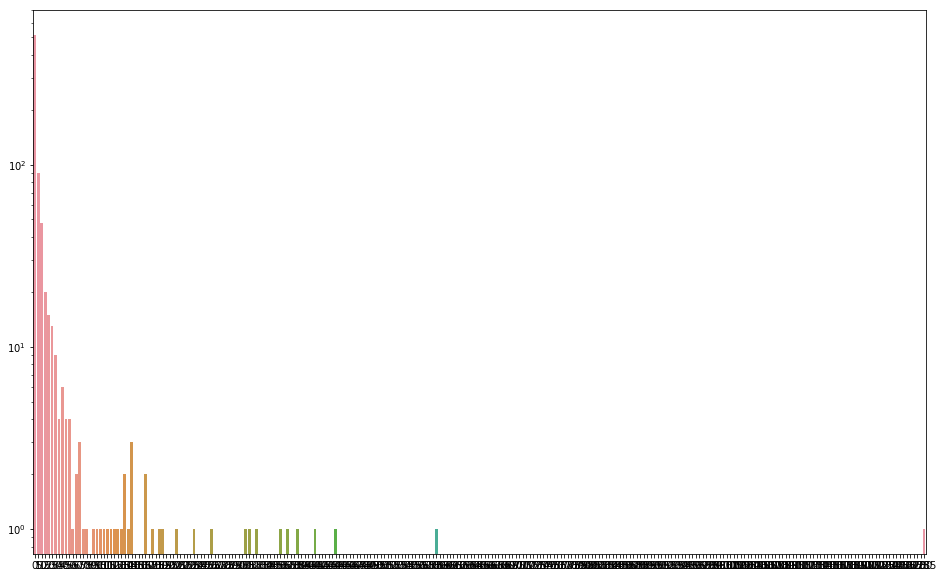

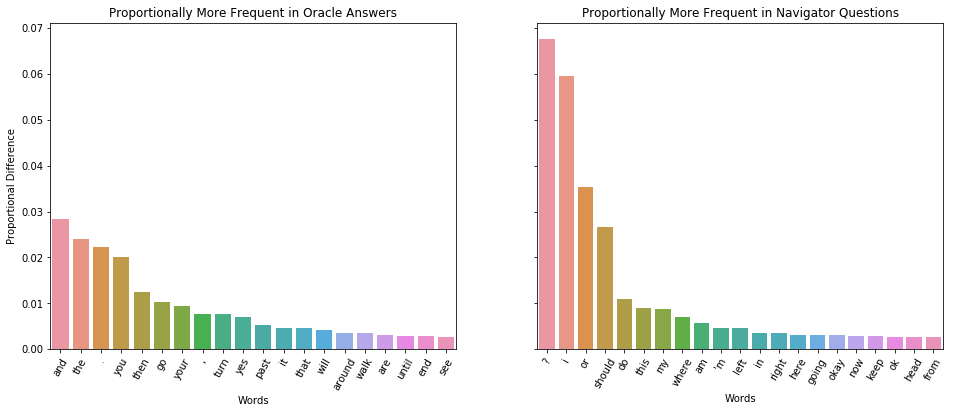

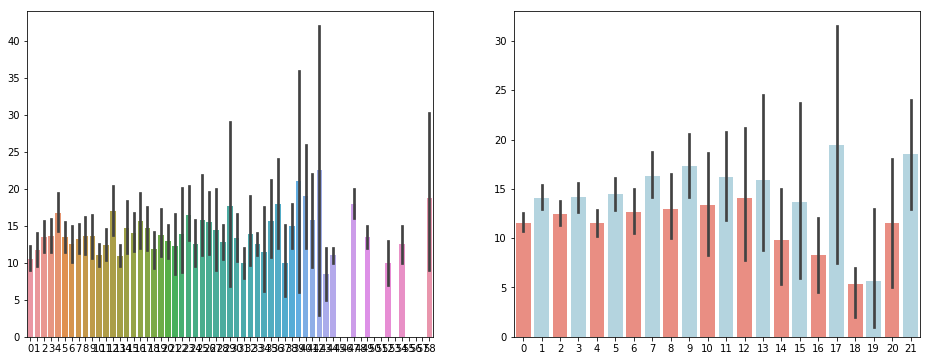

In [106]:
# Distribution of 1 grams
all_cw = flip_dict(all_wc)

bin_size = 5
freq_count_bins = {}
for w in all_wc:
    c = all_wc[w]
    cbin = c // bin_size
    if cbin not in freq_count_bins:
        freq_count_bins[cbin] = 0
    freq_count_bins[cbin] += 1
for cbin in range(min(freq_count_bins), max(freq_count_bins)):
    if cbin not in freq_count_bins:
        freq_count_bins[cbin] = 0
        
fig, ax = plt.subplots(figsize=(16, 10))
g = sns.barplot(ax=ax,
                x=[k * bin_size for k in freq_count_bins],
                y=[freq_count_bins[k] for k in freq_count_bins])
ax.set(yscale="log")
plt.show()

# Differences between navigator and oracle utterances
all_voc = set(all_wc.keys())
nav_wc_sum = sum([nav_wc[token] for token in nav_wc])
norm_nav_wc = {token: nav_wc[token] / nav_wc_sum if token in nav_wc else 0 for token in all_voc}
ora_wc_sum = sum([ora_wc[token] for token in ora_wc])
norm_ora_wc = {token: ora_wc[token] / ora_wc_sum if token in ora_wc else 0 for token in all_voc}
sum_ora_diffs = {token: norm_nav_wc[token] - norm_ora_wc[token] for token in all_voc}
tk_diffs = sorted(sum_ora_diffs.items(), key=lambda kv: kv[1])

threshold = 0.0025
rotation = 60
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(16, 6))
ax1.title.set_text('Proportionally More Frequent in Oracle Answers')
ax1.set(xlabel='Words', ylabel='Proportional Difference')
g1 = sns.barplot(x=[pair[0] for pair in tk_diffs if pair[1] < -threshold],
            y=np.array([-pair[1] for pair in tk_diffs  if pair[1] < -threshold]), ax=ax1)
g1.set_xticklabels(ax1.get_xticklabels(), rotation=rotation)
ax2.title.set_text("Proportionally More Frequent in Navigator Questions")
ax2.set(xlabel='Words')
g2 = sns.barplot(x=[pair[0] for pair in reversed(tk_diffs) if pair[1] > threshold],
            y=np.array([pair[1] for pair in reversed(tk_diffs) if pair[1] > threshold]), ax=ax2)
g2.set_xticklabels(ax2.get_xticklabels(), rotation=rotation)
plt.show()

# Utterance length against navigation step and dialog turn.
# TODO: two nav bars per step, one for navigator, one for oracle
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(16, 6))
g1 = sns.barplot(data=len_at_nav_turn, ax=ax1)
g2 = sns.barplot(data=len_at_dialog_turn, ax=ax2,
                palette=['salmon' if idx % 2 == 0 else 'lightblue' for idx in range(len(len_at_dialog_turn))])
plt.show()

In [107]:
# Note train/val unseen/test scans and ratios.
r2r_data_dir = '../../../tasks/R2R/data/'
r2r_data_folds = ["train", "val_seen", "val_unseen", "test"]
scans_by_fold = {}
trajs_by_fold = {}
for data_fold in r2r_data_folds:
    scans_by_fold[data_fold] = set()
    trajs_by_fold[data_fold] = 0
    with open(os.path.join(r2r_data_dir, "R2R_%s.json" % data_fold), 'r') as f:
        mp_data = json.load(f)
    for trajectory in mp_data:
        scans_by_fold[data_fold].add(trajectory['scan'])
        trajs_by_fold[data_fold] += 1
prop_val_seen = trajs_by_fold['val_seen'] / (trajs_by_fold['val_seen'] + trajs_by_fold['train'])
prop_train = trajs_by_fold['train'] / (trajs_by_fold['val_seen'] + trajs_by_fold['train'])

# Split games into train/val seen/val unseen/test.
np.random.seed(37)  # fix the seed so train/val_seen splits are identical given same data
assigned_train = None  # indices assigned to train
folds_to_games = {}
for fold in r2r_data_folds:
    gidxs = [idx for idx in games.index if games['scan'][idx] in scans_by_fold[fold]]
    if fold == "train":
        indices = list(range(len(gidxs)))
        np.random.shuffle(indices)
        train_n = min(int(np.round(prop_train * len(gidxs))), len(indices) - 1)
        assigned_train = set([gidxs[idx] for idx in indices[:train_n]])
        gidxs = assigned_train
    elif fold == "val_seen":
        indices = list(range(len(gidxs)))
        gidxs = [gidx for gidx in gidxs if gidx not in assigned_train]
    folds_to_games[fold] = gidxs

print("fold, num games")
for fold in r2r_data_folds:
    print("%s, %s" % (fold, len(folds_to_games[fold])))

fold, num games
train, 84
val_seen, 6
val_unseen, 25
test, 28


In [116]:
# Carve out the Instruction Following task.
ins_follow = pd.DataFrame(columns=["game_idx",  # meta - the game dialog from which this was extracted.
                                   "scan",  # setting - the house the task takes place in.
                                   "target",  # setting - the target object for the task.
                                   "start_pano",  # setting - the starting pano and camera angles for navigation.
                                   "dialog_history",  # input - dialog history so far.
                                   "nav_history",  # input - navigation pano steps so far.
                                   "nav_camera",  # input - camera movements at last pano up to question.
                                   "planner_path",  # output - the planner sequence steps shown to the oracle.
                                   "player_path",  # output - the steps the navigator actually took.
                                   "R2R_success",  # meta - whether this traj was a success by R2R standards.
                                   "R2R_oracle_success",  # meta - whether traj passed close enough to "target".
                                   "R2R_spl",  # meta - trajectory R2R spl score.
                                   "R2R_oracle_spl",  # meta - trajectory oracle (passed) spl score.
                                   "navigator_game_quality",  # meta - the quality score the oracle gave navigator.
                                   "oracle_game_quality",  # meta - the quality score the navigator gave oracle.
                                   "navigator_worker_quality",  # meta - scores for navigator across games.
                                   "oracle_worker_quality",  # meta - scores for oracle across games.
                                   # TODO: add quality scores to ins_follow and other tasks.
                                  ])
q_asking = pd.DataFrame(columns=["game_idx",  # meta - the game dialog from which this was extracted.
                                 "scan",  # setting - the house the task takes place in.
                                 "target",  # setting - the target object for the task.
                                 "start_pano",  # setting - the starting pano and camera angles for navigation.
                                 "dialog_history",  # input - dialog history so far.
                                 "nav_history",  # input - navigation pano steps so far.
                                 "nav_camera",  # input - camera movements at last pano up to question.
                                 "nav_question",  # output - the question the navigator asked at this step.
                                ])
q_answering = pd.DataFrame(columns=["game_idx",  # meta - the game dialog from which this was extracted.
                                    "scan",  # setting - the house the task takes place in.
                                    "target",  # setting - the target object for the task.
                                    "start_pano",  # setting - the starting pano and camera angles for navigation.
                                    "dialog_history",  # input - dialog history so far.
                                    "nav_history",  # input - navigation pano steps so far.
                                    "nav_camera",  # input - camera movements at last pano up to question.
                                    "planner_path",  # input - the planner sequence steps shown to the oracle.
                                    "oracle_answer",  # output - the answer the oracle gave
                                ])

for idx in games.index:
    for tidx in range(len(games['dialog_history'][idx])):
        turn = games['dialog_history'][idx][tidx]
        if turn['role'] == 'oracle':  # Create a new instance of the instruction following task.
            
            # dialog history is everything before this answer + this answer.
            dialog_history = games['dialog_history'][idx][:tidx + 1]
            dialog_history = [{c: entry[c] for c in ['message', 'role', 'nav_idx']} for entry in dialog_history]

            # nav steps are all steps taken before this q and the one from which this q was answered.
            nav_steps = games['nav_steps'][idx][:turn['nav_idx'] + 1]
            
            # nav camera movements are those associated with this answers nav question.
            nav_camera = None
            for nav_camera_entry in games['nav_camera'][idx]:
                if nav_camera_entry['dia_idx'] == tidx - 1:  # e.g., -1 from oracle answer to nav question.
                    nav_camera = nav_camera_entry['message']
                    
            # the last message from the camera movements is our starting pano+angles
            start_pano = nav_camera[-1]
            # calculate the planner steps shown to the oracle from here to min(goal, +5) ahead.
            shortest_traj = get_shortest_planner_path(games['scan'][idx],
                                                      start_pano['pano'],
                                                      games['end_panos'][idx])
            planner_steps = shortest_traj[:min(5, len(shortest_traj))]
            
            # record the player steps taken until the next question was asked / goal was reached.
            if tidx + 1 < len(games['dialog_history'][idx]):
                next_nav_idx = games['dialog_history'][idx][tidx + 1]['nav_idx']
            else:
                next_nav_idx = len(games['nav_steps'][idx]) - 1
            # Navigator did not move before asking another question.
            if next_nav_idx == turn['nav_idx']:
                continue
            player_steps = list(games['nav_steps'][idx])[turn['nav_idx']:next_nav_idx + 1]
            
            ins_follow = ins_follow.append({"game_idx": idx,
                                            "scan": games['scan'][idx],
                                            "target": games['target'][idx],
                                            "start_pano": start_pano,
                                            "dialog_history": dialog_history,
                                            "nav_history": nav_steps,
                                            "nav_camera": nav_camera,
                                            "planner_path": planner_steps,
                                            "player_path": player_steps,
                                            "R2R_success": int(calculate_success(
                                                games['scan'][idx],
                                                player_steps,
                                                planner_steps,
                                                within_meters=METERS_FOR_SUCCESS)),
                                            "R2R_oracle_success": int(calculate_oracle_success(
                                                games['scan'][idx],
                                                player_steps,
                                                planner_steps,
                                                within_meters=METERS_FOR_SUCCESS)),
                                            "R2R_spl": float(calculate_spl(
                                                games['scan'][idx],
                                                player_steps,
                                                planner_steps,
                                                within_meters=METERS_FOR_SUCCESS)),
                                            "R2R_oracle_spl": float(calculate_oracle_spl(
                                                games['scan'][idx],
                                                player_steps,
                                                planner_steps,
                                                within_meters=METERS_FOR_SUCCESS)),
                                           }, ignore_index=True)
            q_asking = q_asking.append({"game_idx": idx,
                                        "scan": games['scan'][idx],
                                        "target": games['target'][idx],
                                        "start_pano": start_pano,
                                        # strip nav q & oracle ans.
                                        "dialog_history": dialog_history[:-2],
                                        "nav_history": nav_steps,
                                        "nav_camera": nav_camera,
                                        # target is the nav q asked here.
                                        "nav_question": dialog_history[-2]['message'],
                                       }, ignore_index=True)
            q_answering = q_answering.append({"game_idx": idx,
                                              "scan": games['scan'][idx],
                                              "target": games['target'][idx],
                                              "start_pano": start_pano,
                                              # strip oracle ans from input.
                                              "dialog_history": dialog_history[:-1],
                                              "nav_history": nav_steps,
                                              "nav_camera": nav_camera,
                                              "planner_path": planner_steps,
                                              # target is oracle answer.
                                              "oracle_answer": dialog_history[-1]['message'],
                                           }, ignore_index=True)

# Write task data to human-readable JSON files.
for fold in r2r_data_folds:
    d = [{c: ins_follow[c][idx] for c in ins_follow.keys()}
         for idx in ins_follow.index
         if ins_follow["game_idx"][idx] in folds_to_games[fold]]
    fn = os.path.join(instruction_following_dir, "%s.json" % fold)
    with open(fn, 'w') as f:
        json.dump(d, f, indent=2)
    print("Wrote %d instances to '%s'" % (len(d), fn))
        
    d = [{c: q_asking[c][idx] for c in q_asking.keys()}
         for idx in q_asking.index
         if q_asking["game_idx"][idx] in folds_to_games[fold]]
    fn = os.path.join(question_asking_dir, "%s.json" % fold)
    with open(fn, 'w') as f:
        json.dump(d, f, indent=2)
    print("Wrote %d instances to '%s'" % (len(d), fn))

    d = [{c: q_answering[c][idx] for c in q_answering.keys()}
         for idx in q_answering.index
         if q_answering["game_idx"][idx] in folds_to_games[fold]]
    fn = os.path.join(question_answering_dir, "%s.json" % fold)
    with open(fn, 'w') as f:
        json.dump(d, f, indent=2)
    print("Wrote %d instances to '%s'" % (len(d), fn))
    
    d = [{c: games[c][idx] for c in games.keys()}
         for idx in games.index
         if idx in folds_to_games[fold]]
    fn = os.path.join(dialog_navigation_dir, "%s.json" % fold)
    with open(fn, 'w') as f:
        for game in d:
            for k in game:
                if type(game[k]) == np.int64:
                    game[k] = int(game[k])
                elif type(game[k]) == np.float64:
                    game[k] = float(game[k])
        json.dump(d, f, indent=2)
    print("Wrote %d instances to '%s'" % (len(d), fn))

Wrote 232 instances to '../tasks/instruction_following/train.json'
Wrote 232 instances to '../tasks/question_asking/train.json'
Wrote 232 instances to '../tasks/question_answering/train.json'
Wrote 84 instances to '../tasks/dialog_navigation/train.json'
Wrote 25 instances to '../tasks/instruction_following/val_seen.json'
Wrote 25 instances to '../tasks/question_asking/val_seen.json'
Wrote 25 instances to '../tasks/question_answering/val_seen.json'
Wrote 6 instances to '../tasks/dialog_navigation/val_seen.json'
Wrote 76 instances to '../tasks/instruction_following/val_unseen.json'
Wrote 76 instances to '../tasks/question_asking/val_unseen.json'
Wrote 76 instances to '../tasks/question_answering/val_unseen.json'
Wrote 25 instances to '../tasks/dialog_navigation/val_unseen.json'
Wrote 84 instances to '../tasks/instruction_following/test.json'
Wrote 84 instances to '../tasks/question_asking/test.json'
Wrote 84 instances to '../tasks/question_answering/test.json'
Wrote 28 instances to '../t

In [109]:
# Inspect open feedback.
for wid, feedback in feedbacks:
    if len(feedback.strip()) > 0:
        print("%s: %s" % (wid, feedback.strip()))

A1AKL5YH9NLD2V: It's hard to know what type of questions to ask when I don't know what the interface of the other person is. I didn't know if they could see what I was looking at or not.
AO33H4GL9KZX9: this feels like it takes too long especially when i'm waiting for the partner to reply.
A2YE7NBCK14VAQ: it was kind of hard to figure out whether they needed to go up the stairs or not but nothing too confusing
A1YCGICA8XCNBH: sad they never even said anything.
A1H1TKK54YG94Q: It took probably the first question to sort of "get it" from my perspective as I think my initial instructions weren't great, but got much better.
A3PTO0DMF57GDG: thank you partner
A38LEVBZ3P5F6T: We managed to reach our goal without any difficulty. Thanks for the interesting HIT!
A3CPQP08A6J09F: My partner was great, very responsive and asked great questions and followed directions well.
A3LE1BIVORW3VR: Thank you so much! I hope you can enable the arrow keys on the keyboard to move across the given scenarios
A13WY

In [111]:
# Inspect dialogs.
print(len(games))
for idx in games.index:
    print("idx %d:\nhouse %s, target %s, dialog len %d, nav len %d" %
          (games['idx'][idx], games['scan'][idx], games['target'][idx], len(games['dialog_history'][idx]),
           len(games['nav_steps'][idx])))
    print("navigator quality: %d, oracle quality: %d" % (games['navigator_quality'][idx], games['oracle_quality'][idx]))
    for tidx in range(len(games['dialog_history'][idx])):
        turn = games['dialog_history'][idx][tidx]
        print("\t[%d] %s(%s):\t%s" % (turn['nav_idx'], turn['role'], turn['uid'], turn['message']))
    print()

143
idx 0:
house 82sE5b5pLXE, target trashcan, dialog len 6, nav len 26
navigator quality: 4, oracle quality: 4
	[11] navigator(5d01b554b2aa7):	Should I go up the stairs or toward the toilet?
	[11] oracle(5d01b4e132804):	yes i believe so
	[11] navigator(5d01b554b2aa7):	Can you be more specific. Up the stairs or move toward the toilet?
	[11] oracle(5d01b4e132804):	don't go up the stairs look to your right and it's not in the bathroom find a couch
	[22] navigator(5d01b554b2aa7):	Is that the couch I am looking for?
	[22] oracle(5d01b4e132804):	it is blue in color has many pillows on it

idx 1:
house RPmz2sHmrrY, target trashcan, dialog len 6, nav len 14
navigator quality: 5, oracle quality: 5
	[0] navigator(5d01b8d157b38):	where do I go?
	[0] oracle(5d01b89ecba6c):	I need you to head to a hallway.
	[5] navigator(5d01b8d157b38):	I am in the hall way
	[5] oracle(5d01b89ecba6c):	Great!  Head to the end of the hall.  When you get to the door with the snowmen, turn right into that room.
	[13] 

In [92]:
# See players' success rates, ratings, and existing qualifications.
import csv
qual_fn = "resources/worker_quals.csv"  # The workers CSV downloaded from Mturk on the "Manage Workers" tab.
qual_csv = pd.read_csv(qual_fn)
players = {}
for idx in games.index:
    for role in ['navigator', 'oracle']:
        if games[role][idx] not in uids_to_workers:
            print("WARNING: uid '%s' missing from known workers but has finished, added game" % games[role][idx])
            continue
        if games['%s_quality' % role][idx] == -1:
            continue
        wid = uids_to_workers[games[role][idx]]
        if wid not in players:
            row_v = qual_csv.loc[qual_csv['Worker ID'] == wid, 'CURRENT-MP-Dialog']
            if not np.isnan(row_v.values[0]):
                existing_qual = row_v.values[0]
            else:
                existing_qual = 0
            players[wid] = {"qual": existing_qual, "uids": [], "pids": [], "game_idxs": [], "ratings": []}
        players[wid]["uids"].append(games[role][idx])
        players[wid]["pids"].append(games['navigator' if role == 'oracle' else 'oracle'][idx])
        players[wid]["game_idxs"].append(games['idx'][idx])
        players[wid]["ratings"].append(games['%s_quality' % role][idx])
blacklist = ['A31681CCEVDIH3']  # Players to qual at 3 no matter what because of bad behavior.
timeout_whitelist = ['AKVQTFH16ICGZ']  # Players we trust based on email communication, etc, to override timeout qual.
qual_level = 4
qualed_count = 0
for wid in players:
    avg_r = np.average(players[wid]['ratings'])
    rounded_qual = int(avg_r + 0.5)
    update_str = ''
    updated_qual = None
    if rounded_qual != players[wid]['qual']:
        updated_qual = int(rounded_qual)
        update_str = "UPDATING TO %d" % updated_qual
    if wid in workers_to_timeouts:
        if wid in timeout_whitelist:
            print("WARNING: whitelisting %s who has %d submitted timeouts" % (wid, workers_to_timeouts[wid]))
        else:
            updated_qual = min(3, int(rounded_qual))
            if updated_qual != players[wid]['qual']:
                update_str = "TIMEOUT! FLOORING TO %d" % updated_qual
    if wid in blacklist:
        updated_qual = 3
        update_str = "BLACKLIST fixed qual %d" % updated_qual
    if updated_qual is not None:
        qual_csv.at[qual_csv['Worker ID'] == wid, 'UPDATE-MP-Dialog'] = updated_qual
        if updated_qual >= qual_level:
            qualed_count += 1
    else:
        if players[wid]['qual'] >= qual_level:
            qualed_count += 1
    print("%s avg rating %.2f [qual=%d] %s" % (wid, avg_r, players[wid]['qual'], update_str))
    print("\t" + ", ".join(["%d(g=%d)" % (players[wid]['ratings'][idx], players[wid]['game_idxs'][idx])
                            for idx in range(len(players[wid]['game_idxs']))]))
    if wid in workers_to_timeouts:
        print("\t%d submitted timeouts" % workers_to_timeouts[wid])
print("%d/%d workers have qual>=%d" % (qualed_count, len(players), qual_level))
with open(qual_fn + ".update.csv", 'w') as f:
    f.write(qual_csv.to_csv(index=False, quoting=csv.QUOTE_ALL, float_format="%.0f"))

A2LU259QPV1I4V avg rating 5.00 [qual=5] 
	5(g=31)
A1CMWA0L8FTSXA avg rating 5.00 [qual=5] 
	5(g=48)
A20FTMW1E6AR1T avg rating 3.00 [qual=3] 
	3(g=7)
A11EL5LWS2L1HX avg rating 4.38 [qual=4] 
	5(g=13), 4(g=22), 4(g=42), 3(g=43), 5(g=47), 4(g=48), 5(g=61), 5(g=65), 5(g=72), 5(g=76), 4(g=79), 3(g=80), 5(g=84), 5(g=88), 2(g=92), 5(g=104), 5(g=110), 5(g=111), 5(g=114), 4(g=115), 5(g=122), 4(g=127), 3(g=129), 5(g=136)
A2JHF7CU91EVXW avg rating 5.00 [qual=0] UPDATING TO 5
	5(g=46)
A2A52EATFDQJ1P avg rating 4.00 [qual=4] 
	4(g=58)
A1OZPLHNIU1519 avg rating 4.00 [qual=4] 
	3(g=10), 5(g=52)
A33UMG50QSJ7KS avg rating 5.00 [qual=5] 
	5(g=45)
AHBWX3WYMAB0E avg rating 3.00 [qual=3] 
	3(g=37)
A2UTDZAZV1DF0N avg rating 5.00 [qual=5] 
	5(g=8)
A38LEVBZ3P5F6T avg rating 5.00 [qual=5] 
	5(g=3)
A14OPFM8OFA4WF avg rating 2.00 [qual=2] 
	2(g=56)
A2LC2DS8OH7NCA avg rating 5.00 [qual=5] 
	5(g=3)
A31681CCEVDIH3 avg rating 4.61 [qual=5] BLACKLIST fixed qual 3
	3(g=17), 5(g=20), 4(g=25), 5(g=34), 5(g=39), 5(g=49),